In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import statsmodels.api as sm
from scipy.stats import norm

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

## 1. Load the Data

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id','start_date']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2013-08-29 22:00:00+00:00,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2013-08-29 22:00:00+00:00,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,2013-08-29 22:30:00+00:00,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412710,2013,1,regular,True,False,3746.0,2013-08-29 23:00:00+00:00,2710,Western Illinois,MVFC,fcs,42.0,NaN,2261,Hampton,MEAC,fcs,9.0,NaN
4,332412050,2013,1,regular,True,False,3919.0,2013-08-29 23:00:00+00:00,2050,Ball State,Mid-American,fbs,51.0,NaN,2287,Illinois State,MVFC,fcs,28.0,NaN


In [5]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        df_season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = df_games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            df_tmp = pd.DataFrame([val.to_dict() for val in data])
            if df_tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            df_tmp.columns = convert_to_snake_case(df_tmp.columns)

            df_tmp['clock_minutes'] = df_tmp['clock'].apply(lambda x: x['minutes'])
            df_tmp['clock_seconds'] = df_tmp['clock'].apply(lambda x: x['seconds'])
            df_tmp.drop(columns=['clock'], inplace=True)

            df_tmp = df_tmp[cols]
            season_dfs.append(df_tmp)
        
        df_season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        df_season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, df_tmp

    all_dfs.append(df_season_plays)

    del df_season_plays
    
df_plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [6]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,333272229,2013,13,regular,2013-11-23 23:00:00+00:00,False,Florida International,Conference USA,Marshall,Conference USA,218,FIU Stadium,78.1,70.0,76.0,0.0,0,70.0,5.8,1015.9,NaN,None
1,333062229,2013,10,regular,2013-11-02 22:00:00+00:00,False,Florida International,Conference USA,East Carolina,Conference USA,218,FIU Stadium,84.9,65.8,53.0,0.0,0,260.0,7.0,1010.5,NaN,None
2,332992229,2013,9,regular,2013-10-26 22:00:00+00:00,False,Florida International,Conference USA,Louisiana Tech,Conference USA,218,FIU Stadium,79.0,61.0,54.0,0.0,0,60.0,11.4,1018.2,NaN,None
3,332852229,2013,7,regular,2013-10-12 23:30:00+00:00,False,Florida International,Conference USA,UAB,Conference USA,218,FIU Stadium,81.0,66.2,61.0,0.0,0,50.0,8.1,1015.9,NaN,None
4,332572229,2013,3,regular,2013-09-14 22:00:00+00:00,False,Florida International,Conference USA,Bethune-Cookman,MEAC,218,FIU Stadium,88.0,73.8,63.0,0.0,0,110.0,11.4,1013.0,NaN,None


In [7]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    df_venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    df_venues = pd.DataFrame([val.to_dict() for val in data])
    df_venues.columns = convert_to_snake_case(df_venues.columns)
    df_venues.to_parquet(file_path)

df_venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [8]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
df_elos = pd.concat(elos, ignore_index=True).reset_index(drop=True)
df_elos = df_elos.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
df_elos.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


In [9]:
# Load lines data
all_dfs = []

lines_dir = join(DATA_DIR, 'lines')
if not os.path.exists(lines_dir):
    os.makedirs(lines_dir)


for year in YEARS:
    file_path = join(lines_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} lines data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.BettingApi(api_client)
            data = api_instance.get_lines(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_lines = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)

df_lines_exploded = df_lines.explode('lines')

df_lines_exploded['provider'] = df_lines_exploded['lines'].apply(lambda x: x['provider'] if pd.notnull(x) else None)
df_lines_exploded['spread'] = df_lines_exploded['lines'].apply(lambda x: x['spread'] if pd.notnull(x) and 'spread' in x else None)

unique_providers = df_lines_exploded['provider'].dropna().unique()

df_spreads = df_lines_exploded.pivot_table(
    index=[col for col in df_lines_exploded.columns if col not in ['lines', 'provider', 'spread']],
    columns='provider',
    values='spread',
    aggfunc='first'
).reset_index()

df_spreads.columns = [f'{col}_spread' if col in unique_providers else col for col in df_spreads.columns]

df_lines = df_lines.drop(columns=['lines']).drop_duplicates().merge(
    df_spreads,
    on=[col for col in df_lines.columns if col != 'lines'],
    how='left'
)

del df_lines_exploded, df_spreads

df_lines["home_spread"] = (
    df_lines["consensus_spread"]
    .fillna(df_lines["teamrankings_spread"])
    .fillna(df_lines["numberfire_spread"])
    .fillna(df_lines["Bovada_spread"])
    .fillna(df_lines["ESPN Bet_spread"])
    .fillna(df_lines["DraftKings_spread"])
    .fillna(df_lines["Caesars_spread"])
    .fillna(df_lines["SugarHouse_spread"])
    .fillna(df_lines["William Hill (New Jersey)_spread"])
    .fillna(df_lines["Caesars Sportsbook (Colorado)_spread"])
    .fillna(df_lines["Caesars (Pennsylvania)_spread"])
)

df_lines.head()

Reading ../data/lines/2013.parquet from cached data
Reading ../data/lines/2014.parquet from cached data
Reading ../data/lines/2015.parquet from cached data
Reading ../data/lines/2016.parquet from cached data
Reading ../data/lines/2017.parquet from cached data
Reading ../data/lines/2018.parquet from cached data
Reading ../data/lines/2019.parquet from cached data
Reading ../data/lines/2020.parquet from cached data
Reading ../data/lines/2021.parquet from cached data
Reading ../data/lines/2022.parquet from cached data
Reading ../data/lines/2023.parquet from cached data
Reading ../data/lines/2024.parquet from cached data


,id,season,season_type,week,start_date,home_team,home_conference,home_score,away_team,away_conference,away_score,home_division,away_division,Bovada_spread,Caesars_spread,Caesars (Pennsylvania)_spread,Caesars Sportsbook (Colorado)_spread,DraftKings_spread,ESPN Bet_spread,SugarHouse_spread,William Hill (New Jersey)_spread,consensus_spread,numberfire_spread,teamrankings_spread,home_spread
0,332430194,2013,regular,1,2013-08-31 16:00:00+00:00,Ohio State,Big Ten,40.0,Buffalo,Mid-American,20.0,fbs,fbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.5,-33.5,-34.0,-33.5
1,332412393,2013,regular,1,2013-08-29 23:30:00+00:00,Middle Tennessee,Conference USA,45.0,Western Carolina,Southern,24.0,fbs,fcs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.0,NaN,NaN,-12.0
2,332410238,2013,regular,1,2013-08-30 01:15:00+00:00,Vanderbilt,SEC,35.0,Ole Miss,SEC,39.0,fbs,fbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,3.0,3.0,-1.5
3,332410023,2013,regular,1,2013-08-30 02:00:00+00:00,San José State,Mountain West,24.0,Sacramento State,Big Sky,0.0,fbs,fcs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.0,NaN,NaN,-33.0
4,332410278,2013,regular,1,2013-08-30 02:30:00+00:00,Fresno State,Mountain West,52.0,Rutgers,American Athletic,51.0,fbs,fbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.5,-10.5,-10.0,-8.5


## 2. Join the Data

In [26]:
play_cols = [
    'game_id','drive_id','id','offense','period','clock_minutes','clock_seconds',
    'offense_score','defense_score', 'offense_timeouts','defense_timeouts',
    'yards_to_goal','down','distance', 'play_type','play_text'
]
game_cols = [
    'season','week','id','season_type','neutral_site','venue_id', 'completed',
    'home_id','home_team','home_conference',
    'away_id','away_team','away_conference',
]
venue_cols = [
    'id', 'elevation', 'grass'
]
elo_cols = ['season', 'week', 'division', 'team_id', 'elo']
weather_cols = [
    'id','precipitation','wind_speed','temperature','game_indoors'
]
spread_cols = ['id','home_spread']

df = (
    df_plays[play_cols].rename(columns={'id':'play_id'})
    .query('down==4')
    .assign(
        clock_minutes=lambda x: np.maximum(np.minimum(x['clock_minutes'], 15), 0),
        clock_seconds=lambda x: np.maximum(np.minimum(x['clock_seconds'], 59), 0),
        offense_score=lambda x: np.maximum(x['offense_score'], 0),
        defense_score=lambda x: np.maximum(x['defense_score'], 0),
    )
    .assign(
        pct_game_played=lambda x: (((x['period'] - 1) * 15 * 60) + (15* 60) - 
                                   (x['clock_minutes'] * 60 + x['clock_seconds'])
                                   ) / (15 * 60 * 4),
        score_diff=lambda x: x['offense_score'] - x['defense_score'],
    )
    .query('0 < period <= 4')
    .query('0 <= yards_to_goal <= 100')
    .query('0 <= distance <= 100')
    # .drop(columns=['period','clock_minutes','clock_seconds'])
    .merge(
        df_games[game_cols].rename(columns={'id':'game_id'}),
        how='left',
        on=['game_id']
    )
    .query('completed == True')
    .assign(
        is_home_team=lambda x: np.select([x.neutral_site, x.offense == x.home_team],[0, 1], default=-1),
    )
    .merge(
        df_venues[venue_cols].rename(columns={'id':'venue_id'}),
        how='left',
        on=['venue_id']
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'home_id', 
                                          'division': 'home_division', 
                                          'elo': 'home_pregame_elo'}),
        on=['season', 'week', 'home_id'],
        how='left'
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'away_id', 
                                          'division': 'away_division', 
                                          'elo': 'away_pregame_elo'}),
        on=['season', 'week', 'away_id'],
        how='left'
    )
    .assign(
        pregame_elo_diff=lambda x: np.where(
            x.offense == x.home_team,
            x.home_pregame_elo - x.away_pregame_elo,
            x.away_pregame_elo - x.home_pregame_elo
        ),
        pregame_offense_elo=lambda x: np.where(
            x.offense == x.home_team,
            x.home_pregame_elo,
            x.away_pregame_elo
        ),
        pregame_defense_elo=lambda x: np.where(
            x.offense == x.home_team,
            x.away_pregame_elo,
            x.home_pregame_elo
        ),
    )
    .merge(
        df_weather[weather_cols].rename(columns={'id':'game_id'}),
        how='left',
        on=['game_id']
    )
    .assign(
        distance=lambda x: np.where(
            x.yards_to_goal - x.distance < 0,
            x.yards_to_goal,
            x.distance
        )
    )
    .merge(
        df_lines[spread_cols].rename(columns={'id': 'game_id'}),
        on=['game_id'],
        how='left'
    )
)

df['pressure_rating'] = np.select(
    [
        (df['pct_game_played'] >= (58 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 2 min
        (df['pct_game_played'] >= (55 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 5 - 2 min
        (df['pct_game_played'] >= (50 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 10 - 5 min
        (df['pct_game_played'] >= (45 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 15 - 10 min
    ],
    [4, 3, 2, 1],
    default=0
)

df = df.assign(
    offense_division = np.where(df['offense'] == df['home_team'], df['home_division'], df['away_division']),
    defense_division = np.where(df['offense'] == df['home_team'], df['away_division'], df['home_division']),
    grass = df.grass.fillna(False),
    game_indoors = df.game_indoors.fillna(False),
    temperature = df.temperature.fillna(int(df.temperature.mean())),
    wind_speed = np.where(df.game_indoors, 0, df.wind_speed.fillna(int(df.wind_speed.mean()))),
    elevation = df.elevation.fillna(int(df.elevation.astype(float).mean())),
    precipitation = np.where(df.game_indoors, 0, df.precipitation.fillna(int(df.precipitation.mean()))),
    defense_timeouts = np.minimum(np.maximum(df.defense_timeouts, 0), 3),
    offense_timeouts = np.minimum(np.maximum(df.offense_timeouts, 0), 3),
)
df['elevation'] = df['elevation'].astype(float)    

df.head()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_63878/1123240938.py:117: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grass = df.grass.fillna(False),
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_63878/1123240938.py:118: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_indoors = df.game_indoors.fillna(False),


,game_id,drive_id,play_id,offense,period,clock_minutes,clock_seconds,offense_score,defense_score,offense_timeouts,defense_timeouts,yards_to_goal,down,distance,play_type,play_text,pct_game_played,score_diff,season,week,season_type,neutral_site,venue_id,completed,home_id,home_team,home_conference,away_id,away_team,away_conference,is_home_team,elevation,grass,home_division,home_pregame_elo,away_division,away_pregame_elo,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,precipitation,wind_speed,temperature,game_indoors,home_spread,pressure_rating,offense_division,defense_division
0,333610120,33361012026,333610120256,Maryland,4,0,50,20,31,0.0,2.0,66,4,4,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,0.986111,-11,2013,1,postseason,True,3852.0,True,120,Maryland,ACC,276,Marshall,Conference USA,0,10.749901,False,fbs,1921.246102,fbs,1703.121251,218.124852,1921.246102,1703.121251,0.0,9.2,46.0,False,3.0,0,fbs,fbs
1,333610120,33361012022,333610120226,Maryland,4,5,53,20,24,3.0,3.0,87,4,5,Punt,"Nathan Renfro punt for 45 yards, returned by D...",0.901944,-4,2013,1,postseason,True,3852.0,True,120,Maryland,ACC,276,Marshall,Conference USA,0,10.749901,False,fbs,1921.246102,fbs,1703.121251,218.124852,1921.246102,1703.121251,0.0,9.2,46.0,False,3.0,0,fbs,fbs
2,333610120,33361012010,333610120093,Maryland,2,7,49,10,17,3.0,3.0,68,4,3,Punt,"Nathan Renfro punt for 38 yards, fair catch by...",0.369722,-7,2013,1,postseason,True,3852.0,True,120,Maryland,ACC,276,Marshall,Conference USA,0,10.749901,False,fbs,1921.246102,fbs,1703.121251,218.124852,1921.246102,1703.121251,0.0,9.2,46.0,False,3.0,0,fbs,fbs
3,333610120,33361012004,333610120027,Maryland,1,8,9,0,0,3.0,3.0,97,4,8,Punt,"Nathan Renfro punt for 34 yards, returned by D...",0.114167,0,2013,1,postseason,True,3852.0,True,120,Maryland,ACC,276,Marshall,Conference USA,0,10.749901,False,fbs,1921.246102,fbs,1703.121251,218.124852,1921.246102,1703.121251,0.0,9.2,46.0,False,3.0,0,fbs,fbs
4,333610120,33361012002,333610120012,Maryland,1,11,33,0,0,3.0,3.0,86,4,18,Punt,"Nathan Renfro punt for 47 yards, returned by D...",0.057500,0,2013,1,postseason,True,3852.0,True,120,Maryland,ACC,276,Marshall,Conference USA,0,10.749901,False,fbs,1921.246102,fbs,1703.121251,218.124852,1921.246102,1703.121251,0.0,9.2,46.0,False,3.0,0,fbs,fbs


In [27]:
# Impute the missing point spread values

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

cols = ['game_id', 'home_spread', 'home_pregame_elo', 'away_pregame_elo']
df_spred_pred = df[cols].query('home_spread.notnull() and home_pregame_elo.notnull() and away_pregame_elo.notnull()').drop_duplicates('game_id')

X = df_spred_pred[['home_pregame_elo', 'away_pregame_elo']]
y = df_spred_pred['home_spread']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

df['home_spread_pred'] = model.predict(df[['home_pregame_elo', 'away_pregame_elo']])

df['home_spread'] = df['home_spread'].fillna(df['home_spread_pred'])
df.drop(columns=['home_spread_pred'], inplace=True)

MAE: 5.772868613829573


In [28]:
df = (
    df
    .assign(
        game_seconds_remaining = ((4 * 15 * 60) - ((df['period'] - 1) * 15 * 60 + (15 * 60) - (df['clock_minutes'] * 60 + df['clock_seconds']))),
        pregame_spread = np.where(df['offense'] == df['home_team'], df['home_spread'], -df['home_spread']),
    )

    .assign(
        diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['game_seconds_remaining']) / 3600),
        spread_time_ratio = lambda x: x['pregame_spread'] * np.exp(4 * (3600 - x['game_seconds_remaining']) / 3600),
    )
)

df.head()

,game_id,drive_id,play_id,offense,period,clock_minutes,clock_seconds,offense_score,defense_score,offense_timeouts,defense_timeouts,yards_to_goal,down,distance,play_type,play_text,pct_game_played,score_diff,season,week,season_type,neutral_site,venue_id,completed,home_id,home_team,home_conference,away_id,away_team,away_conference,is_home_team,elevation,grass,home_division,home_pregame_elo,away_division,away_pregame_elo,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,precipitation,wind_speed,temperature,game_indoors,home_spread,pressure_rating,offense_division,defense_division,game_seconds_remaining,pregame_spread,diff_time_ratio,spread_time_ratio
0,333610120,33361012026,333610120256,Maryland,4,0,50,20,31,0.0,2.0,66,4,4,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,0.986111,-11,2013,1,postseason,True,3852.0,True,120,Maryland,ACC,276,Marshall,Conference USA,0,10.749901,False,fbs,1921.246102,fbs,1703.121251,218.124852,1921.246102,1703.121251,0.0,9.2,46.0,False,3.0,0,fbs,fbs,50,3.0,-568.124007,154.942911
1,333610120,33361012022,333610120226,Maryland,4,5,53,20,24,3.0,3.0,87,4,5,Punt,"Nathan Renfro punt for 45 yards, returned by D...",0.901944,-4,2013,1,postseason,True,3852.0,True,120,Maryland,ACC,276,Marshall,Conference USA,0,10.749901,False,fbs,1921.246102,fbs,1703.121251,218.124852,1921.246102,1703.121251,0.0,9.2,46.0,False,3.0,0,fbs,fbs,353,3.0,-147.535989,110.651992
2,333610120,33361012010,333610120093,Maryland,2,7,49,10,17,3.0,3.0,68,4,3,Punt,"Nathan Renfro punt for 38 yards, fair catch by...",0.369722,-7,2013,1,postseason,True,3852.0,True,120,Maryland,ACC,276,Marshall,Conference USA,0,10.749901,False,fbs,1921.246102,fbs,1703.121251,218.124852,1921.246102,1703.121251,0.0,9.2,46.0,False,3.0,0,fbs,fbs,2269,3.0,-30.716471,13.164202
3,333610120,33361012004,333610120027,Maryland,1,8,9,0,0,3.0,3.0,97,4,8,Punt,"Nathan Renfro punt for 34 yards, returned by D...",0.114167,0,2013,1,postseason,True,3852.0,True,120,Maryland,ACC,276,Marshall,Conference USA,0,10.749901,False,fbs,1921.246102,fbs,1703.121251,218.124852,1921.246102,1703.121251,0.0,9.2,46.0,False,3.0,0,fbs,fbs,3189,3.0,0.000000,4.736408
4,333610120,33361012002,333610120012,Maryland,1,11,33,0,0,3.0,3.0,86,4,18,Punt,"Nathan Renfro punt for 47 yards, returned by D...",0.057500,0,2013,1,postseason,True,3852.0,True,120,Maryland,ACC,276,Marshall,Conference USA,0,10.749901,False,fbs,1921.246102,fbs,1703.121251,218.124852,1921.246102,1703.121251,0.0,9.2,46.0,False,3.0,0,fbs,fbs,3393,3.0,0.000000,3.775800


In [29]:
rush = (
    df['play_text'].str.contains('rush', case=False) |
    df['play_text'].str.contains('run', case=False) |
    df['play_text'].str.contains('scramble', case=False) |
    (df['play_type'] == 'Rush')
)
pass_ = (
    df['play_text'].str.contains('pass', case=False) |
    df['play_text'].str.contains('throw', case=False) |
    df['play_text'].str.contains('sack', case=False) |
    df['play_text'].str.contains('intercept', case=False) |
    (df['play_type'].str.contains('Pass', case=False)) |
    (df['play_type'].str.contains('Sack', case=False)) 
)
punt = (
    df['play_text'].str.contains('punt', case=False) |
    df['play_type'].str.contains('Punt', case=False) | 
    (df.play_type == 'Punt')
)
field_goal = (
    df['play_text'].str.contains('field goal', case=False) |
    df['play_text'].str.contains('fg', case=False) |
    df['play_type'].str.contains('Field Goal', case=False)
)
penalty = (
    df['play_text'].str.contains('penalty', case=False) |
    df['play_type'].str.contains('Penalty', case=False) |
    df['play_text'].str.contains('illegal', case=False) |
    df['play_text'].str.contains('offside', case=False) |
    df['play_text'].str.contains('false start', case=False) |
    df['play_text'].str.contains('delay of game', case=False) |
    df['play_text'].str.contains('pass interference', case=False) |
    df['play_text'].str.contains('holding', case=False) |
    df['play_text'].str.contains('personal foul', case=False) |
    df['play_text'].str.contains('roughing', case=False) |
    df['play_text'].str.contains('unsportsmanlike', case=False) |
    df['play_text'].str.contains('taunting', case=False)
)
kneel = (
    df['play_text'].str.contains('kneel', case=False) |
    df['play_type'].str.contains('Kneel', case=False)
)
timeout = (
    df['play_text'].str.contains('timeout', case=False) |
    df['play_type'].str.contains('Timeout', case=False)
)
kickoff = (
    df['play_text'].str.contains('kickoff', case=False) |
    df['play_type'].str.contains('Kickoff', case=False)
)
end_of_period = (
    df['play_text'].str.contains('end ', case=False) |
    df['play_type'].str.contains('end ', case=False)
)
safety = (
    df['play_text'].str.contains('safety', case=False) |
    df['play_type'].str.contains('Safety', case=False)
)

df = df.assign(
    action=np.select(
        [
            penalty, end_of_period, timeout, kneel, kickoff,  field_goal, punt, rush, pass_, 
            safety
        ],
        [
            'penalty', 'end_of_period', 'timeout', 'kneel', 'kickoff', 'field_goal', 'punt', 'rush', 
            'pass', 'safety'
        ],
        default='other'
    )
)

drop_actions = [
    'penalty', 'timeout', 'kickoff', 'end_of_period', 'safety', 'kneel', 'other'
]
df = df.query('action not in @drop_actions').reset_index(drop=True)

df['decision'] = np.select(
    [
        df['action'].isin(['rush', 'pass']),
        df['action'] == 'punt',
        df['action'] == 'field_goal'
    ],
    [
        'go', 'punt', 'field_goal'
    ],
    default=-1
)

df.action.value_counts()

action
punt          108445
field_goal     32894
pass           20605
rush           20054
Name: count, dtype: int64

In [30]:
df.play_type.value_counts()

play_type
Punt                                  107378
Field Goal Good                        24331
Rush                                   17578
Pass Incompletion                       8404
Field Goal Missed                       7610
Pass Reception                          7548
Passing Touchdown                       1653
Rushing Touchdown                       1616
Sack                                    1425
Blocked Field Goal                       851
Blocked Punt                             792
Pass Completion                          608
Pass Interception Return                 577
Fumble Recovery (Opponent)               445
Fumble Recovery (Own)                    374
Interception                             223
Punt Return Touchdown                    143
Blocked Punt Touchdown                   110
Safety                                    85
Interception Return Touchdown             79
Pass Interception                         58
Blocked Field Goal Touchdown              49


In [31]:
df.decision.value_counts()

decision
punt          108445
go             40659
field_goal     32894
Name: count, dtype: int64

In [32]:
df = df.query('~((action == "field_goal") & (yards_to_goal > 60))').reset_index(drop=True)
df = df.query('offense_division == "fbs" or defense_division == "fbs"').reset_index(drop=True)

In [33]:
df.decision.value_counts()

decision
punt          92915
go            34249
field_goal    28474
Name: count, dtype: int64

# 3. Make Predictions

### i. Load the models

In [34]:
model_dir = os.path.join(DATA_DIR, 'models', 'fg_probability')

# read the statsmodel probit models as pkl files
fg_selection_model = sm.load(join(model_dir, 'selection_model.pkl'))
fg_outcome_model = sm.load(join(model_dir, 'outcome_model.pkl'))

In [35]:
model_dir = os.path.join(DATA_DIR, 'models', 'fourth_down')
fourth_down_model = xgb.Booster(model_file=join(model_dir, 'xgb_classifier.json'))

In [36]:
model_dir = os.path.join(DATA_DIR, 'models', 'punt_yards_to_goal')
punt_model = xgb.Booster(model_file=join(model_dir, 'xgb_classifier.json'))

In [37]:
model_dir = os.path.join(DATA_DIR, 'models', 'win_probability')
wp_model = xgb.Booster(model_file=join(model_dir, 'xgb_classifier.json'))

### ii. Win Probability with FG Make & Miss

In [47]:
selection_features = [
    'yards_to_goal', 'score_diff', 'pct_game_played', 'pregame_offense_elo', 
    'pregame_defense_elo', 'distance', 'pressure_rating', 'is_home_team',
    'wind_speed', 'temperature',
    'elevation', 'grass', 'game_indoors'
]
outcome_features = [
    'yards_to_goal', 'score_diff', 'pregame_offense_elo', 
    'pregame_defense_elo', 'pressure_rating',
    'wind_speed', 'elevation'
]
wp_features = [
    'diff_time_ratio',
    'score_diff',
    'spread_time_ratio',
    'pregame_spread',
    'is_home_team',
    'offense_timeouts',
    'defense_timeouts',
    'yards_to_goal'
]

five_seconds_pct = 5 / (15 * 60 * 4)

# Assumptions: 
# 1. Kicking a FG takes 5 seconds off the clock
# 2. The receiving team yards to goal post FG attempt is 80 yards
#NOTE: this is WP team of the team NOT kicking the FG
wp_make_data = (
    df.assign(
        diff_time_ratio=lambda x: (-x['score_diff'] - 3) * np.exp(4 * (3600 - np.maximum(x['game_seconds_remaining'] - 5, 0)) / 3600),
        score_diff=lambda x: -x['score_diff'] - 3,
        spread_time_ratio=lambda x: (-x['pregame_spread']) * np.exp(4 * (3600 - np.maximum(x['game_seconds_remaining'] - 5, 0)) / 3600),
        pregame_spread=lambda x: -x['pregame_spread'],
        is_home_team=lambda x: np.select([x['is_home_team'] == 1, x['is_home_team'] == -1], [-1, 1], default=0),
        offense_timeouts_new=lambda x: x.defense_timeouts,
        defense_timeouts_new=lambda x: x.offense_timeouts,
        yards_to_goal=80,
        pct_game_played=lambda x: np.minimum(x['pct_game_played'] + five_seconds_pct, 1.0)
    )
    .drop(columns=['offense_timeouts','defense_timeouts'])
    .rename(columns={
        'offense_timeouts_new':'offense_timeouts',
        'defense_timeouts_new':'defense_timeouts'
    })
    [wp_features + ['pct_game_played']]
)

#NOTE: this is WP team of the team NOT kicking the FG
wp_miss_data = (
    df.assign(
        diff_time_ratio=lambda x: (-x['score_diff']) * np.exp(4 * (3600 - np.maximum(x['game_seconds_remaining'] - 5, 0)) / 3600),
        score_diff=lambda x: (-1 * x['score_diff']),
        spread_time_ratio=lambda x: (-x['pregame_spread']) * np.exp(4 * (3600 - np.maximum(x['game_seconds_remaining'] - 5, 0)) / 3600),
        pregame_spread=lambda x: -x['pregame_spread'],
        is_home_team=lambda x: np.select([x['is_home_team'] == 1, x['is_home_team'] == -1], [-1, 1], default=0),
        offense_timeouts_new=lambda x: x.defense_timeouts,
        defense_timeouts_new=lambda x: x.offense_timeouts,
        yards_to_goal=lambda x: 100 - x['yards_to_goal'],
        pct_game_played=lambda x: np.minimum(x['pct_game_played'] + five_seconds_pct, 1.0),
    )
    .drop(columns=['offense_timeouts','defense_timeouts'])
    .rename(columns={
        'offense_timeouts_new':'offense_timeouts',
        'defense_timeouts_new':'defense_timeouts'
    })
    [wp_features + ['pct_game_played']]
)


print('Predicting FG probabilities')

# Predict Selection Model Probit Scores
X_sel = (
    df[selection_features].copy()
    .assign(
        grass=df['grass'].astype(int),
        game_indoors=df['game_indoors'].astype(int),
    )
)
X_sel = sm.add_constant(X_sel)
probit_score = fg_selection_model.predict(X_sel)
# Inverse Mills Ratio
phi = norm.pdf(probit_score)
Phi = norm.cdf(probit_score)
lambda_ = phi / Phi
# Predict Outcome Model Probit Scores
X_out = df[outcome_features].copy().assign(**{'lambda': lambda_})
X_out = sm.add_constant(X_out)
df['fg_proba'] = fg_outcome_model.predict(X_out).round(4)

# Hardcoded probabilities for long FG attempts
rules = [
    ('50 <= yards_to_goal <= 52', 0.15),
    ('53 <= yards_to_goal <= 55', 0.11),
    ('56 <= yards_to_goal <= 58', 0.07),
    ('59 <= yards_to_goal <= 61', 0.03),
    ('62 <= yards_to_goal <= 64', 0.01),
    ('65 <= yards_to_goal <= 70', 0.0001),
    ('yards_to_goal > 70', 0.0)
]
for rule, base_prob in rules:
    df.loc[df.query(rule).index, 'fg_proba'] = base_prob


print('Predicting win probabilities after FG Make')
dmatrix = xgb.DMatrix(wp_make_data[wp_features])

# the "1 -" here is to flip the WP back to the team that is kicking the FG
probas = 1 - wp_model.predict(dmatrix).reshape(-1,1)

# Set WP to 1 or 0 if the game is over after the FG
probas[(wp_make_data['pct_game_played'] == 1.0) & ((-1 * wp_make_data['score_diff']) > 0)] = 1.0
probas[(wp_make_data['pct_game_played'] == 1.0) & ((-1 * wp_make_data['score_diff']) < 0)] = 0.0

# round probas to 3 decimal places
df['wp_make_proba'] = np.round(probas, 3)


print('Predicting win probabilities after FG Miss')
wp_miss_probas = []
dmatrix = xgb.DMatrix(wp_miss_data[wp_features])

# the "1 -" here is to flip the WP back to the team that is kicking the FG
probas = 1 - wp_model.predict(dmatrix).reshape(-1,1)

# Set WP to 1 or 0 if the game is over after the FG
probas[(wp_miss_data['pct_game_played'] == 1.0) & ((-1 * wp_miss_data['score_diff']) > 0)] = 1.0
probas[(wp_miss_data['pct_game_played'] == 1.0) & ((-1 * wp_miss_data['score_diff']) < 0)] = 0.0

# round probas to 3 decimal places
df['wp_miss_proba'] = np.round(probas, 3)

df['exp_wp_fg'] = (df['fg_proba'] * df['wp_make_proba']) + ((1 - df['fg_proba']) * df['wp_miss_proba']).round(4)

Predicting FG probabilities
Predicting win probabilities after FG Make
Predicting win probabilities after FG Miss


In [48]:
df.query('wp_make_proba < wp_miss_proba').shape[0] / df.shape[0]

0.001240057055474884

In [49]:
df.query('wp_make_proba < wp_miss_proba')[[
       'score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'offense_timeouts','defense_timeouts','yards_to_goal', 'wp_make_proba', 'wp_miss_proba',
    ]].assign(wp_diff=lambda x: x.wp_miss_proba - x.wp_make_proba).sort_values('wp_diff', ascending=False).head(30)

,score_diff,pregame_elo_diff,pct_game_played,is_home_team,offense_timeouts,defense_timeouts,yards_to_goal,wp_make_proba,wp_miss_proba,wp_diff
54177,-6,142.322205,0.426389,1,3.0,1.0,8,0.774,0.844,0.070
72656,-3,-398.190073,0.132500,1,3.0,1.0,4,0.405,0.462,0.057
97079,-10,328.042068,0.288889,1,3.0,1.0,4,0.770,0.823,0.053
83878,-10,1063.052084,0.384167,1,3.0,1.0,8,0.842,0.872,0.030
115976,-7,1444.840724,0.358889,1,2.0,1.0,6,0.804,0.831,0.027
137612,1,722.318816,0.473056,1,3.0,1.0,6,0.892,0.916,0.024
72762,-4,714.751815,0.423889,1,3.0,1.0,5,0.844,0.866,0.022
93772,3,570.857932,0.446667,1,3.0,1.0,1,0.869,0.891,0.022
103421,-4,450.023901,0.467778,1,3.0,1.0,7,0.828,0.849,0.021
126625,-7,577.388818,0.293333,-1,3.0,1.0,3,0.786,0.807,0.021


In [50]:
df.drop(columns=['wp_make_proba', 'wp_miss_proba'], inplace=True)

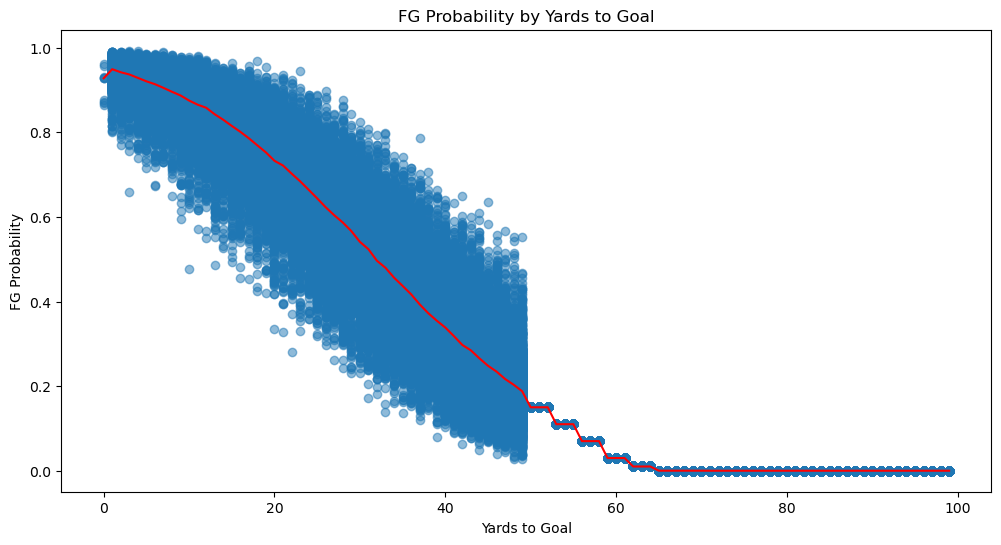

In [51]:
import matplotlib.pyplot as plt

df_fg_proba = pd.DataFrame(
    np.hstack([df.yards_to_goal.values.reshape(-1, 1), df.fg_proba.values.reshape(-1, 1)]), 
    columns=['fg_distance', 'fg_proba']
)

df_fg_proba_grouped = df_fg_proba.groupby('fg_distance').agg(
    median_probability=('fg_proba', 'median'),
    count=('fg_proba', 'count')
).reset_index()

# plot the median yards_to_goal by punt_team_end_yards_to_goal
plt.figure(figsize=(12, 6))
plt.scatter(df_fg_proba.fg_distance, df_fg_proba.fg_proba, alpha=0.5)
#plot the median yards_to_goal by punt_team_end_yards_to_goal
plt.plot(df_fg_proba_grouped.fg_distance, df_fg_proba_grouped.median_probability, color='red', label='Median Probability')
plt.xlabel('Yards to Goal')
plt.ylabel('FG Probability')
plt.title('FG Probability by Yards to Goal')
plt.show()

### iii. Win Probability with 4th Down Conversion Success & Failure

In [87]:
fourth_down_data = (
    df[[   
        'distance','score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'precipitation', 'wind_speed', 'temperature', 'yards_to_goal',
    ]]
)

fourth_down_probas = []
for model in tqdm(fourth_down_models, desc='Predicting Fourth Down probabilities'):
    dmatrix = xgb.DMatrix(fourth_down_data)
    probas_fourth_down = model.predict(dmatrix).reshape(-1, 1).round(4)
    fourth_down_probas.append(probas_fourth_down)
fourth_down_probas_matrix = np.hstack(fourth_down_probas)

df['fourth_down_proba'] = np.percentile(fourth_down_probas_matrix, 50, axis=1)


five_seconds_pct = 5 / (15 * 60 * 4)

# WP Assumptions: 
# 1. Fourth down attempt takes 5 seconds off the clock
# 2. Only assuming they pick up exactly the yards needed for the first down (conservative estimate)
# 3. On a touchdown, the receiving team gets the ball at the 80 yard line
# 4. If the yards to goal is LEQ 1, then the offense team scores a touchdown if they convert
#NOTE: this is the WP of the offense team if distance != yards_to_goal, else the WP of the defense team
wp_convert_data = (
    df[[
       'score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'offense_timeouts','defense_timeouts','yards_to_goal', 'distance'
    ]].copy()
    .assign(
        score_diff=lambda x: np.where(
            x.yards_to_goal <= 1,  # if scored touchdown
            (-1 * x['score_diff']) - 7, # flip defense to offense team
            x['score_diff']
        ),
        pregame_elo_diff=lambda x: np.where(
            x.yards_to_goal <= 1,   # if scored touchdown
            x['pregame_elo_diff'] * -1, # flip defense to offense team
            x['pregame_elo_diff']
        ),
        pct_game_played=lambda x: np.minimum(x['pct_game_played'] + five_seconds_pct, 1.0),
        is_home_team=lambda x: np.where(
            x.yards_to_goal <= 1, # if scored touchdown
            np.select([x['is_home_team'] == 1, x['is_home_team'] == -1], [-1, 1], default=0), 
            x['is_home_team']
        ),
        offense_timeouts_new=lambda x: np.where(
            x.yards_to_goal <= 1, # if scored touchdown
            x['defense_timeouts'],
            x['offense_timeouts']
        ),
        defense_timeouts_new=lambda x: np.where(
            x.yards_to_goal <= 1, # if scored touchdown
            x['offense_timeouts'],
            x['defense_timeouts']
        ),
        yards_to_goal=lambda x: np.where(
            x.yards_to_goal <= 1, # if scored touchdown
            80,
            x['yards_to_goal'] - x['distance']
        )
    )
    .drop(columns=['distance', 'offense_timeouts', 'defense_timeouts'])
    .rename(columns={
        'offense_timeouts_new': 'offense_timeouts',
        'defense_timeouts_new': 'defense_timeouts'
    })
    [[
        'score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'offense_timeouts','defense_timeouts','yards_to_goal'
    ]]
)

# Assumptions:
# 1. Assumes 4th down attempt gains zero yards on failure
#NOTE: this is WP of the team defending the fourth down attempt after the attempt
wp_fail_data = (
    df[[
       'score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'offense_timeouts','defense_timeouts','yards_to_goal'
    ]].copy()
    .assign(
        score_diff=lambda x: x.score_diff * -1,
        pregame_elo_diff=lambda x: x['pregame_elo_diff'] * -1,
        pct_game_played=lambda x: np.minimum(x['pct_game_played'] + five_seconds_pct, 1.0),
        is_home_team=lambda x: np.select([x['is_home_team'] == 1, x['is_home_team'] == -1], [-1, 1], default=0),
        offense_timeouts_new=lambda x: x.defense_timeouts,
        defense_timeouts_new=lambda x: x.offense_timeouts,
        yards_to_goal=lambda x: 100 - x['yards_to_goal']
    )
    .drop(columns=['offense_timeouts','defense_timeouts'])
    .rename(columns={
        'offense_timeouts_new':'offense_timeouts',
        'defense_timeouts_new':'defense_timeouts'
    })
    [[
        'score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'offense_timeouts','defense_timeouts','yards_to_goal'
    ]]
)

wp_convert_probas = []
for model in tqdm(wp_models, desc='Predicting win probabilities after 4th Down Convertion'):
    dmatrix = xgb.DMatrix(wp_convert_data)

    # If the conversion leads to a TD, then flip the WP back from defense to offense
    probas = model.predict(dmatrix).reshape(-1, 1)
    probas = np.where(
        df.yards_to_goal.values.reshape(-1, 1) <= 1,
        1 - probas,
        probas
    )

    # Set WP to 1 or 0 if the game is over after the FG
    pct_game_played = wp_convert_data['pct_game_played'].values
    yards_to_goal = df.yards_to_goal.values
    score_diff = wp_convert_data['score_diff'].values
    game_over_win = (pct_game_played == 1.0) & (
        ((yards_to_goal <= 1) & ((-1 * score_diff) > 0)) |
        ((yards_to_goal > 1) & (score_diff > 0))
    )
    game_over_loss = (pct_game_played == 1.0) & (
        ((yards_to_goal <= 1) & ((-1 * score_diff) < 0)) |
        ((yards_to_goal > 1) & (score_diff < 0))
    )
    probas[game_over_win] = 1.0
    probas[game_over_loss] = 0.0

    wp_convert_probas.append(probas.round(4))
wp_convert_probas_matrix = np.hstack(wp_convert_probas)

wp_fail_probas = []
for model in tqdm(wp_models, desc='Predicting win probabilities after 4th Down Failure to Convert'):
    dmatrix = xgb.DMatrix(wp_fail_data)
    
    # the "1 -" here is to flip the WP back to the team that is attempting the 4th down
    probas = (1 - model.predict(dmatrix).reshape(-1, 1)).round(4)

    # Set WP to 1 or 0 if the game is over after the FG
    probas[(wp_fail_data['pct_game_played'] == 1.0) & ((-1 * wp_fail_data['score_diff']) > 0)] = 1.0
    probas[(wp_fail_data['pct_game_played'] == 1.0) & ((-1 * wp_fail_data['score_diff']) < 0)] = 0.0

    wp_fail_probas.append(probas)
wp_fail_probas_matrix = np.hstack(wp_fail_probas)

df['wp_convert_proba'] = np.percentile(wp_convert_probas_matrix, 50, axis=1)
df['wp_fail_proba'] = np.percentile(wp_fail_probas_matrix, 50, axis=1)

expected_wps = (
    (wp_convert_probas_matrix * fourth_down_probas_matrix) + 
    (wp_fail_probas_matrix * (1 - fourth_down_probas_matrix))
)

df['exp_wp_go'] = np.percentile(expected_wps, 50, axis=1)

Predicting Fourth Down probabilities: 100%|██████████| 100/100 [00:02<00:00, 34.68it/s]
Predicting win probabilities after 4th Down Convertion: 100%|██████████| 100/100 [00:12<00:00,  8.32it/s]
Predicting win probabilities after 4th Down Failure to Convert: 100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


In [88]:
df.query('wp_convert_proba < wp_fail_proba').shape[0] / df.shape[0]

0.060402986417198885

In [89]:
df.query('wp_convert_proba < wp_fail_proba')[[   
        'distance','score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'precipitation', 'wind_speed', 'temperature', 'yards_to_goal', 'wp_convert_proba','wp_fail_proba',
    ]].assign(wp_diff=lambda x: x.wp_fail_proba - x.wp_convert_proba).sort_values('wp_diff', ascending=False).head(30)

,distance,score_diff,pregame_elo_diff,pct_game_played,is_home_team,precipitation,wind_speed,temperature,yards_to_goal,wp_convert_proba,wp_fail_proba,wp_diff
120771,4,13,-1300.575611,0.445556,1,0.0,8.1,66.9,4,0.50880,0.63315,0.12435
129582,3,14,-1290.865636,0.578333,-1,0.0,5.6,99.1,16,0.57600,0.69085,0.11485
114188,10,10,-1285.321008,0.192222,-1,0.0,3.6,72.7,10,0.23865,0.34125,0.10260
128828,8,7,-1285.030238,0.598611,0,0.0,0.0,66.0,36,0.29175,0.39080,0.09905
56130,11,10,-1336.330326,0.363056,1,0.0,10.3,90.0,11,0.36745,0.45895,0.09150
117549,4,6,-1277.565085,0.784722,1,0.0,4.3,88.3,6,0.42175,0.50865,0.08690
37386,3,14,-1333.203385,0.560833,-1,0.0,12.7,55.0,15,0.57855,0.66355,0.08500
117550,2,3,-1277.565085,0.642500,1,0.0,4.3,88.3,15,0.24580,0.32675,0.08095
44223,1,3,-1338.264400,0.054722,1,0.0,16.1,91.0,6,0.12300,0.20160,0.07860
51604,7,3,-1347.166806,0.167778,1,0.0,21.9,36.0,11,0.15730,0.23405,0.07675


In [90]:
df.drop(columns=['wp_convert_proba', 'wp_fail_proba'], inplace=True)

### iv. Win Probability with Punt

In [91]:
punt_data = (
    df[[
       'yards_to_goal', 'is_home_team', 
       'grass', 'elevation', 'wind_speed', 'precipitation', 'temperature', 'game_indoors',
       'pct_game_played', 'score_diff',
       'pregame_offense_elo', 'pregame_defense_elo',
    ]]
    .rename(columns={
        'yards_to_goal':'punt_team_end_yards_to_goal', 
        'pregame_offense_elo': 'punting_team_pregame_elo',
        'pregame_defense_elo': 'receiving_team_pregame_elo'
    })
)

five_seconds_pct = 5 / (15 * 60 * 4)

# Assumptions: 
# 1. Punt takes 5 seconds off the clock
#NOTE: this is WP of the team receiving the punt
wp_data = (
    df[[
       'score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'offense_timeouts','defense_timeouts','yards_to_goal'
    ]]
    .assign(
        score_diff=lambda x: -1 * x['score_diff'],
        pregame_elo_diff=lambda x: -1 * x['pregame_elo_diff'],
        pct_game_played=lambda x: np.minimum(x['pct_game_played'] + five_seconds_pct, 1.0),
        is_home_team=lambda x: np.select([x['is_home_team'] == 1, x['is_home_team'] == -1], [-1, 1], default=0),
        offense_timeouts_new=lambda x: x.defense_timeouts,
        defense_timeouts_new=lambda x: x.offense_timeouts, 
        yards_to_goal=None # need to fill this with the predicted yards to goal
    )
    .drop(columns=['offense_timeouts','defense_timeouts'])
    .rename(columns={
        'offense_timeouts_new':'offense_timeouts',
        'defense_timeouts_new':'defense_timeouts'
    })
    [[
        'score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'offense_timeouts','defense_timeouts','yards_to_goal'
    ]]
)

yards_to_goals = []
for model in tqdm(punt_models, desc='Predicting receiving team yards to goal'):
    dmatrix = xgb.DMatrix(punt_data)
    ytg = model.predict(dmatrix).reshape(-1, 1).round(4)
    yards_to_goals.append(ytg)
yards_to_goals_matrix = np.hstack(yards_to_goals)

# Calculate the 5%, 50%, 95% percentiles for each sample
# df['punt_yards_to_goal_5'] = np.percentile(yards_to_goals_matrix, 5, axis=1)
# df['punt_yards_to_goal_50'] = np.percentile(yards_to_goals_matrix, 50, axis=1)
# df['punt_yards_to_goal_95'] = np.percentile(yards_to_goals_matrix, 95, axis=1)
df['punt_yards_to_goal'] = np.percentile(yards_to_goals_matrix, 50, axis=1)

wp_probas = []
for yards_to_goal in tqdm(yards_to_goals, desc='Making WP Predictions using predicted yards to goal'):
    for model in wp_models:
        wp_data['yards_to_goal'] = yards_to_goal
        dmatrix = xgb.DMatrix(wp_data)

        # the "1 -" here is to flip the WP back to the team that is punting
        probas = (1 - model.predict(dmatrix).reshape(-1, 1)).round(4)

        # Set WP to 1 or 0 if the game is over after the punt
        probas[(wp_data['pct_game_played'] == 1.0) & ((-1 * wp_data['score_diff']) > 0)] = 1.0
        probas[(wp_data['pct_game_played'] == 1.0) & ((-1 * wp_data['score_diff']) < 0)] = 0.0

        wp_probas.append(probas)

wp_probas_matrix = np.hstack(wp_probas)

# Calculate the 5%, 50%, 95% percentiles for each sample
# df['exp_wp_punt_5'] = np.percentile(wp_probas_matrix, 5, axis=1)
# df['exp_wp_punt_50'] = np.percentile(wp_probas_matrix, 50, axis=1)
# df['exp_wp_punt_95'] = np.percentile(wp_probas_matrix, 95, axis=1)
df['exp_wp_punt'] = np.percentile(wp_probas_matrix, 50, axis=1)

Predicting receiving team yards to goal: 100%|██████████| 100/100 [00:18<00:00,  5.37it/s]
Making WP Predictions using predicted yards to goal: 100%|██████████| 100/100 [22:30<00:00, 13.51s/it]


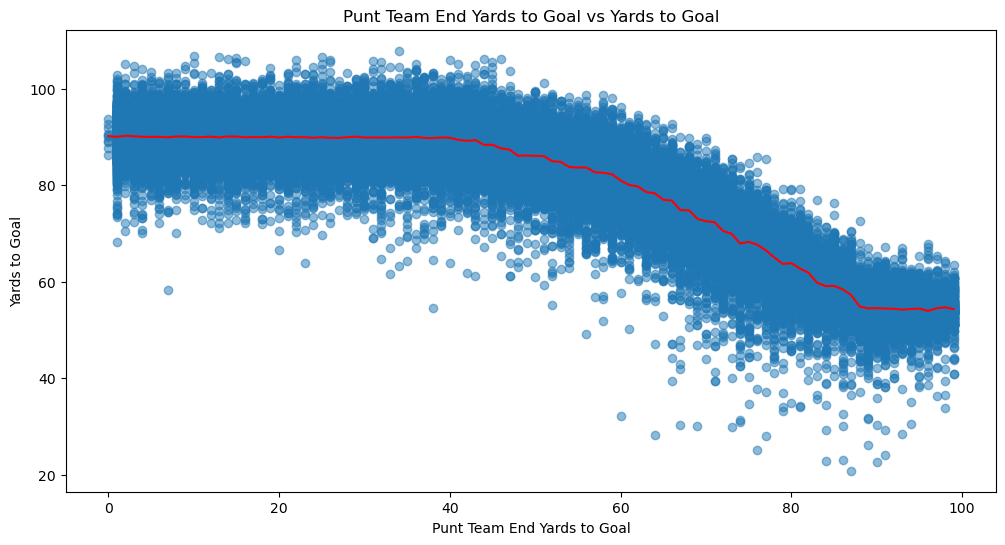

In [92]:
import matplotlib.pyplot as plt

df_ytg = pd.DataFrame(
    np.hstack([punt_data.punt_team_end_yards_to_goal.values.reshape(-1, 1), ytg]), 
    columns=['punt_team_end_yards_to_goal', 'yards_to_goal']
)

df_ytg_grouped = df_ytg.groupby('punt_team_end_yards_to_goal').agg(
    median_yards_to_goal=('yards_to_goal', 'median'),
    mean_yards_to_goal=('yards_to_goal', 'mean'),
    count=('yards_to_goal', 'count')
).reset_index()

# plot the median yards_to_goal by punt_team_end_yards_to_goal
plt.figure(figsize=(12, 6))
plt.scatter(df_ytg.punt_team_end_yards_to_goal, df_ytg.yards_to_goal, alpha=0.5)
#plot the median yards_to_goal by punt_team_end_yards_to_goal
plt.plot(df_ytg_grouped.punt_team_end_yards_to_goal, df_ytg_grouped.median_yards_to_goal, color='red', label='Median Yards to Goal')
plt.xlabel('Punt Team End Yards to Goal')
plt.ylabel('Yards to Goal')
plt.title('Punt Team End Yards to Goal vs Yards to Goal')
plt.show()

### v. Current WP Before Action

In [108]:
curr_wp_data = (
    df[[
       'score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'offense_timeouts','defense_timeouts','yards_to_goal',
    ]]
)

curr_wps = []
for model in tqdm(wp_models, desc='Predicting current win probabilities'):
    dmatrix = xgb.DMatrix(curr_wp_data)
    probas = model.predict(dmatrix).reshape(-1, 1)

    # Set WP to 1 or 0 if the game is over after the FG
    probas[(curr_wp_data['pct_game_played'] == 1.0) & ((curr_wp_data['score_diff']) > 0)] = 1.0
    probas[(curr_wp_data['pct_game_played'] == 1.0) & ((curr_wp_data['score_diff']) < 0)] = 0.0

    # round probas to 3 decimal places
    probas = np.round(probas, 3)

    curr_wps.append(probas)
    
cur_wps_matrix = np.hstack(curr_wps)

# Calculate the 5%, 50%, 95% percentiles for each sample
# df['cur_win_proba_5'] = np.percentile(cur_wps_matrix, 5, axis=1)
# df['cur_win_proba_50'] = np.percentile(cur_wps_matrix, 50, axis=1)
# df['cur_win_proba_95'] = np.percentile(cur_wps_matrix, 95, axis=1)
df['cur_win_proba'] = np.percentile(cur_wps_matrix, 50, axis=1)

Predicting current win probabilities: 100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


# 4. Save the predictions data

In [109]:
# Load teams data
all_dfs = []

teams_dir = join(DATA_DIR, 'teams')
if not os.path.exists(teams_dir):
    os.makedirs(teams_dir)

for year in YEARS:
    file_path = join(teams_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_teams = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_teams.head()

Reading ../data/teams/2013.parquet from cached data
Reading ../data/teams/2014.parquet from cached data
Reading ../data/teams/2015.parquet from cached data
Reading ../data/teams/2016.parquet from cached data
Reading ../data/teams/2017.parquet from cached data
Reading ../data/teams/2018.parquet from cached data
Reading ../data/teams/2019.parquet from cached data
Reading ../data/teams/2020.parquet from cached data
Reading ../data/teams/2021.parquet from cached data
Reading ../data/teams/2022.parquet from cached data
Reading ../data/teams/2023.parquet from cached data
Reading ../data/teams/2024.parquet from cached data


,season,id,school,mascot,abbreviation,alternate_names,conference,classification,color,alternate_color,logos,twitter,location,division
0,2013,2000,Abilene Christian,Wildcats,ACU,"[ACU, Abilene Chrstn]",FCS Independents,fcs,#592d82,#b1b3b3,[http://a.espncdn.com/i/teamlogos/ncaa/500/200...,@ACUFootball,"{'capacity': 12000.0, 'city': 'Abilene', 'cons...",None
1,2013,2005,Air Force,Falcons,AFA,"[AFA, Air Force]",Mountain West,fbs,#004a7b,#ffffff,[http://a.espncdn.com/i/teamlogos/ncaa/500/200...,@AF_Football,"{'capacity': 46692.0, 'city': 'Colorado Spring...",Mountain
2,2013,2006,Akron,Zips,AKR,"[AKR, Akron]",Mid-American,fbs,#00285e,#84754e,[http://a.espncdn.com/i/teamlogos/ncaa/500/200...,@ZipsFB,"{'capacity': 30000.0, 'city': 'Akron', 'constr...",East
3,2013,333,Alabama,Crimson Tide,ALA,"[ALA, Alabama]",SEC,fbs,#9e1632,#ffffff,[http://a.espncdn.com/i/teamlogos/ncaa/500/333...,@AlabamaFTBL,"{'capacity': 101821.0, 'city': 'Tuscaloosa', '...",West
4,2013,2010,Alabama A&M,Bulldogs,AAMU,"[AAMU, Alabama A&M]",SWAC,fcs,#790000,#ffffff,[http://a.espncdn.com/i/teamlogos/ncaa/500/201...,@AAMUFB,"{'capacity': 21000.0, 'city': 'Huntsville', 'c...",East


In [110]:
def get_team_logos(logos):
    if isinstance(logos, (list, np.ndarray)) and len(logos) > 0:
        return logos[0]
    return None

tqdm.pandas()
df_teams['logos'] = df_teams['logos'].progress_apply(get_team_logos)

100%|██████████| 7744/7744 [00:00<00:00, 1611385.14it/s]


In [253]:
cols = [
    'game_id','offense', 'offense_timeouts', 'defense_timeouts', 'home_id', 'home_team', 'home_division',
    'away_id', 'away_team', 'away_division', 'pregame_offense_elo', 'pregame_defense_elo',
    'offense_score', 'defense_score', 'score_diff',
    'yards_to_goal','pct_game_played', 'down', 'distance',
    'cur_win_proba', 'exp_wp_fg', 'exp_wp_go', 'exp_wp_punt',
    'decision'
]

AGGRESSIVNESS_FACTOR = 0.02

STRONG_RECOMMEND = 0.05
RECOMMEND = 0.03
SLIGHT_RECOMMEND = 0.015

res = (
    df[cols]
    .merge(
        df_games[['id', 'season','week','season_type']].rename(columns={'id':'game_id'}),
        how='left',
        on=['game_id']
    )
    .assign(
        offense_id=lambda x: np.where(x['offense'] == x['home_team'], x['home_id'], x['away_id']),
        offense_team=lambda x: np.where(x['offense'] == x['home_team'], x['home_team'], x['away_team']),
        offense_division=lambda x: np.where(x['offense'] == x['home_team'], x['home_division'], x['away_division']),
        defense_id=lambda x: np.where(x['offense'] == x['home_team'], x['away_id'], x['home_id']),
        defense_team=lambda x: np.where(x['offense'] == x['home_team'], x['away_team'], x['home_team']),
        defense_division=lambda x: np.where(x['offense'] == x['home_team'], x['away_division'], x['home_division']),
        wpa_fg=lambda x: x['exp_wp_fg'] - x['cur_win_proba'],
        wpa_go=lambda x: x['exp_wp_go'] - x['cur_win_proba'] + AGGRESSIVNESS_FACTOR,
        wpa_punt=lambda x: x['exp_wp_punt'] - x['cur_win_proba'],
    )
    .merge(
        df_teams[['season','id','color','alternate_color','logos', 'conference']]
        .rename(columns={
            'id':'offense_id', 
            'color':'offense_color', 
            'alternate_color':'offense_alternate_color',
            'logos':'offense_logos',
            'conference':'offense_conference'
        }),
        how='left',
        on=['season','offense_id'],
    )
    .merge(
        df_teams[['season','id','color','alternate_color','logos', 'conference']]
        .rename(columns={
            'id':'defense_id', 
            'color':'defense_color', 
            'alternate_color':'defense_alternate_color',
            'logos':'defense_logos',
            'conference':'defense_conference'
        }),
        how='left',
        on=['season','defense_id'],
    )
    [[
        'season', 'week', 'season_type',
        'offense_id', 'offense_team', 'offense_division', 'offense_conference',
        'offense_color', 'offense_alternate_color', 'offense_logos',
        'defense_id', 'defense_team', 'defense_division', 'defense_conference',
        'defense_color', 'defense_alternate_color', 'defense_logos',
        'offense_timeouts', 'defense_timeouts',
        'pregame_offense_elo', 'pregame_defense_elo',
        'offense_score', 'defense_score', 'score_diff',
        'yards_to_goal','pct_game_played', 'down','distance',
        'wpa_fg', 'wpa_go', 'wpa_punt',
        'cur_win_proba', 'exp_wp_fg', 'exp_wp_go', 'exp_wp_punt',
        'decision'
    ]]
    .assign(
        fg_diff_go=lambda x: x['wpa_fg'] - x['wpa_go'],
        fg_diff_punt=lambda x: x['wpa_fg'] - x['wpa_punt'],
        go_diff_fg=lambda x: x['wpa_go'] - x['wpa_fg'],
        go_diff_punt=lambda x: x['wpa_go'] - x['wpa_punt'],
        punt_diff_fg=lambda x: x['wpa_punt'] - x['wpa_fg'],
        punt_diff_go=lambda x: x['wpa_punt'] - x['wpa_go'],
    )
    .assign(
        recommendation=lambda x: np.select(
            [
                (x['go_diff_fg'] > STRONG_RECOMMEND) & (x['go_diff_punt'] > STRONG_RECOMMEND),
                (x['go_diff_fg'] > RECOMMEND) & (x['go_diff_punt'] > RECOMMEND),
                (x['go_diff_fg'] > SLIGHT_RECOMMEND) & (x['go_diff_punt'] > SLIGHT_RECOMMEND),
                (x['fg_diff_go'] > STRONG_RECOMMEND) & (x['fg_diff_punt'] > STRONG_RECOMMEND),
                (x['fg_diff_go'] > RECOMMEND) & (x['fg_diff_punt'] > RECOMMEND),
                (x['fg_diff_go'] > SLIGHT_RECOMMEND) & (x['fg_diff_punt'] > SLIGHT_RECOMMEND),
                (x['punt_diff_go'] > STRONG_RECOMMEND) & (x['punt_diff_fg'] > STRONG_RECOMMEND),
                (x['punt_diff_go'] > RECOMMEND) & (x['punt_diff_fg'] > RECOMMEND),
                (x['punt_diff_go'] > SLIGHT_RECOMMEND) & (x['punt_diff_fg'] > SLIGHT_RECOMMEND),
                # (x['go_diff_fg'] > RECOMMEND) & (x['go_diff_punt'] > SLIGHT_RECOMMEND),
                # (x['go_diff_punt'] > RECOMMEND) & (x['go_diff_fg'] > SLIGHT_RECOMMEND),
                # (x['fg_diff_go'] > RECOMMEND) & (x['fg_diff_punt'] > SLIGHT_RECOMMEND),
                # (x['fg_diff_punt'] > RECOMMEND) & (x['fg_diff_go'] > SLIGHT_RECOMMEND),
                # (x['punt_diff_go'] > RECOMMEND) & (x['punt_diff_fg'] > SLIGHT_RECOMMEND),
                # (x['punt_diff_fg'] > RECOMMEND) & (x['punt_diff_go'] > SLIGHT_RECOMMEND),

            ],
            [
                'go - strongly recommended',
                'go - recommended',
                'go - slightly recommended',
                'field goal - strongly recommended',
                'field goal - recommended',
                'field goal - slightly recommended',
                'punt - strongly recommended',
                'punt - recommended',
                'punt - slightly recommended',
                # 'go - recommended, could punt',
                # 'go - recommended, could kick field goal',
                # 'field goal - recommended, could punt',
                # 'field goal - recommended, could go for it',
                # 'punt - recommended, could kick field goal',
                # 'punt - recommended, could go for it',
            ],
            default=None
        )
    )
)

res.head()

,season,week,season_type,offense_id,offense_team,offense_division,offense_conference,offense_color,offense_alternate_color,offense_logos,defense_id,defense_team,defense_division,defense_conference,defense_color,defense_alternate_color,defense_logos,offense_timeouts,defense_timeouts,pregame_offense_elo,pregame_defense_elo,offense_score,defense_score,score_diff,yards_to_goal,pct_game_played,down,distance,wpa_fg,wpa_go,wpa_punt,cur_win_proba,exp_wp_fg,exp_wp_go,exp_wp_punt,decision,fg_diff_go,fg_diff_punt,go_diff_fg,go_diff_punt,punt_diff_fg,punt_diff_go,recommendation
0,2013,1,postseason,120,Maryland,fbs,ACC,#D5002B,#ffcd00,http://a.espncdn.com/i/teamlogos/ncaa/500/120.png,276,Marshall,fbs,Conference USA,#00ae42,#be854c,http://a.espncdn.com/i/teamlogos/ncaa/500/276.png,0.0,2.0,1921.246102,1703.121251,20,31,-11,66,0.986111,4,4,-0.0080,0.017099,-0.0040,0.0110,0.0030,0.008099,0.0070,go,-0.025099,-0.0040,0.025099,0.021099,0.0040,-0.021099,go - slightly recommended
1,2013,1,postseason,120,Maryland,fbs,ACC,#D5002B,#ffcd00,http://a.espncdn.com/i/teamlogos/ncaa/500/120.png,276,Marshall,fbs,Conference USA,#00ae42,#be854c,http://a.espncdn.com/i/teamlogos/ncaa/500/276.png,3.0,3.0,1921.246102,1703.121251,20,24,-4,87,0.901944,4,5,-0.0120,0.021423,0.0426,0.2055,0.1935,0.206923,0.2481,punt,-0.033423,-0.0546,0.033423,-0.021177,0.0546,0.021177,punt - slightly recommended
2,2013,1,postseason,120,Maryland,fbs,ACC,#D5002B,#ffcd00,http://a.espncdn.com/i/teamlogos/ncaa/500/120.png,276,Marshall,fbs,Conference USA,#00ae42,#be854c,http://a.espncdn.com/i/teamlogos/ncaa/500/276.png,3.0,3.0,1921.246102,1703.121251,10,17,-7,68,0.369722,4,3,-0.0550,-0.001162,-0.0056,0.3230,0.2680,0.301838,0.3174,punt,-0.053838,-0.0494,0.053838,0.004438,0.0494,-0.004438,None
3,2013,1,postseason,120,Maryland,fbs,ACC,#D5002B,#ffcd00,http://a.espncdn.com/i/teamlogos/ncaa/500/120.png,276,Marshall,fbs,Conference USA,#00ae42,#be854c,http://a.espncdn.com/i/teamlogos/ncaa/500/276.png,3.0,3.0,1921.246102,1703.121251,0,0,0,97,0.114167,4,8,0.0395,0.049763,0.1053,0.4415,0.4810,0.471263,0.5468,punt,-0.010263,-0.0658,0.010263,-0.055537,0.0658,0.055537,punt - strongly recommended
4,2013,1,postseason,120,Maryland,fbs,ACC,#D5002B,#ffcd00,http://a.espncdn.com/i/teamlogos/ncaa/500/120.png,276,Marshall,fbs,Conference USA,#00ae42,#be854c,http://a.espncdn.com/i/teamlogos/ncaa/500/276.png,3.0,3.0,1921.246102,1703.121251,0,0,0,86,0.057500,4,18,-0.0190,0.010086,0.0402,0.5000,0.4810,0.490086,0.5402,punt,-0.029086,-0.0592,0.029086,-0.030114,0.0592,0.030114,punt - recommended


In [237]:
res.recommendation.isna().sum()

61035

In [238]:
res.recommendation.value_counts()

recommendation
go - slightly recommended            49521
punt - slightly recommended          14464
punt - recommended                   12466
punt - strongly recommended           6913
field goal - slightly recommended     4592
field goal - recommended              3129
field goal - strongly recommended     2405
go - recommended                       841
go - strongly recommended              272
Name: count, dtype: int64

In [241]:
cols = ['offense_score', 'defense_score', 'score_diff', 'pregame_offense_elo', 'pregame_defense_elo',
       'yards_to_goal', 'pct_game_played', 'down', 'distance', 'wpa_fg',
       'wpa_go', 'wpa_punt', 'cur_win_proba', 'decision', 'recommendation']
res.query('recommendation == "go - slightly recommended"')[cols].head(20)

,offense_score,defense_score,score_diff,pregame_offense_elo,pregame_defense_elo,yards_to_goal,pct_game_played,down,distance,wpa_fg,wpa_go,wpa_punt,cur_win_proba,decision,recommendation
0,20,31,-11,1921.246102,1703.121251,66,0.986111,4,4,-8.000000e-03,0.017099,-0.00400,0.0110,go,go - slightly recommended
8,13,17,-4,1921.246102,1703.121251,35,0.708889,4,1,-4.319999e-02,0.000598,-0.02520,0.4360,go,go - slightly recommended
9,10,14,-4,1921.246102,1703.121251,7,0.306667,4,7,-3.410001e-02,-0.018496,-0.05060,0.5035,field_goal,go - slightly recommended
12,43,10,33,1921.246102,1388.832367,76,0.898611,4,15,-1.287460e-08,0.020409,0.00060,0.9990,punt,go - slightly recommended
13,40,10,30,1921.246102,1388.832367,60,0.569167,4,5,2.000008e-03,0.021332,0.00260,0.9960,punt,go - slightly recommended
14,40,10,30,1921.246102,1388.832367,52,0.666389,4,23,1.999743e-04,0.020143,0.00070,0.9980,punt,go - slightly recommended
15,43,10,33,1921.246102,1388.832367,5,0.788889,4,5,-1.287460e-08,0.020544,0.00060,0.9990,field_goal,go - slightly recommended
17,40,10,30,1921.246102,1388.832367,24,0.634444,4,2,9.999743e-04,0.019964,0.00080,0.9980,go,go - slightly recommended
21,52,38,14,1883.502643,2094.680419,29,0.935556,4,10,1.800016e-03,0.018281,0.00030,0.9920,field_goal,go - slightly recommended
33,34,7,27,967.974304,1575.662897,68,0.946389,4,5,-2.574921e-08,0.020191,0.00090,0.9980,punt,go - slightly recommended


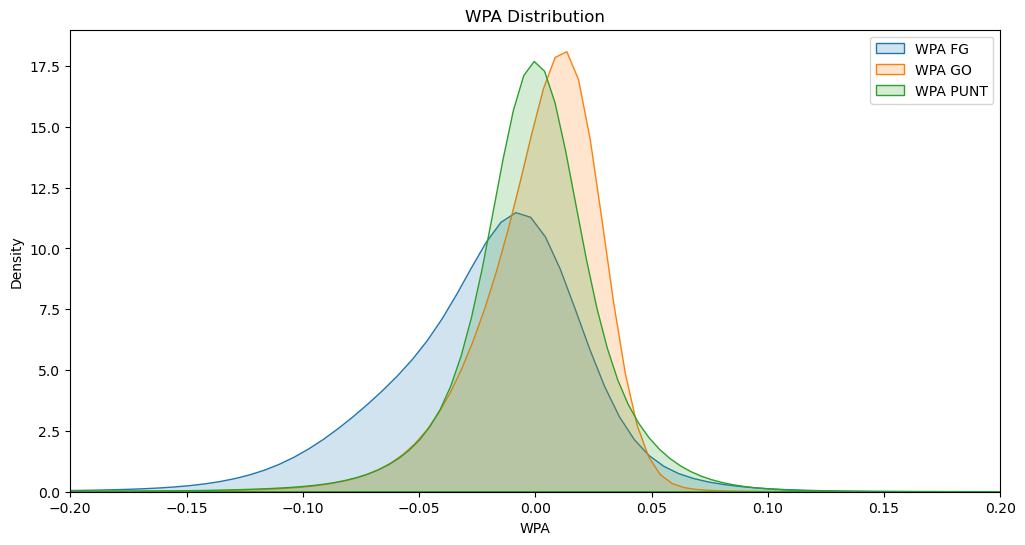

In [245]:
# plot a kde plot of wpa_fg, wpa_go, and wpa_punt using seaborn
import seaborn as sns
plt.figure(figsize=(12, 6))
BW=6
sns.kdeplot(data=res, x='wpa_fg', label='WPA FG', fill=True, alpha=0.2, bw_adjust=BW)
sns.kdeplot(data=res, x='wpa_go', label='WPA GO', fill=True, alpha=0.2, bw_adjust=BW)
sns.kdeplot(data=res, x='wpa_punt', label='WPA PUNT', fill=True, alpha=0.2, bw_adjust=BW)
plt.xlim(-.2, .2)
plt.xlabel('WPA')
plt.ylabel('Density')
plt.title('WPA Distribution')
plt.legend()
plt.show()

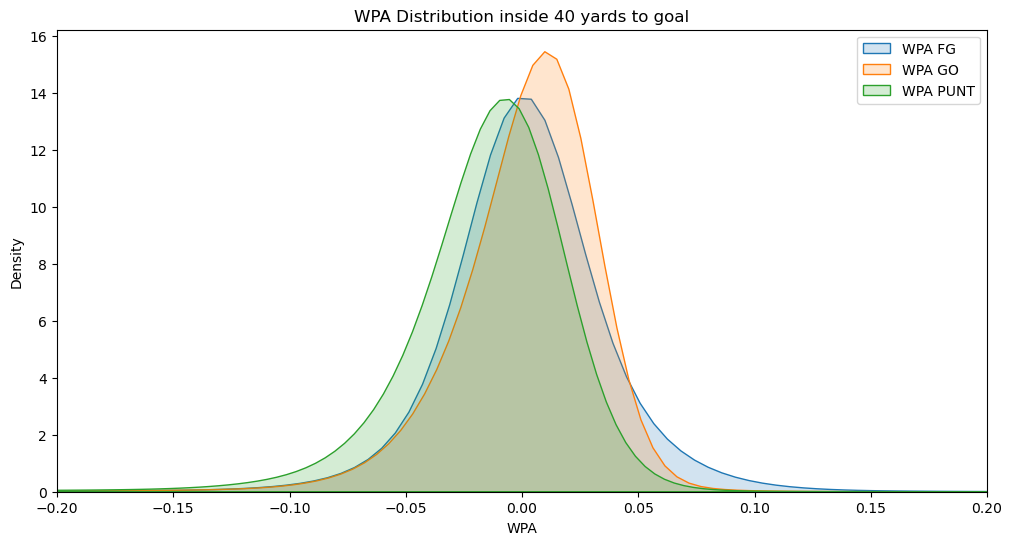

In [246]:
# plot a kde plot of wpa_fg, wpa_go, and wpa_punt using seaborn
import seaborn as sns
plt.figure(figsize=(12, 6))
BW=6
qry = res.query('yards_to_goal <= 40')
sns.kdeplot(data=qry, x='wpa_fg', label='WPA FG', fill=True, alpha=0.2, bw_adjust=BW)
sns.kdeplot(data=qry, x='wpa_go', label='WPA GO', fill=True, alpha=0.2, bw_adjust=BW)
sns.kdeplot(data=qry, x='wpa_punt', label='WPA PUNT', fill=True, alpha=0.2, bw_adjust=BW)
plt.xlim(-.2, .2)
plt.xlabel('WPA')
plt.ylabel('Density')
plt.title('WPA Distribution inside 40 yards to goal')
plt.legend()
plt.show()

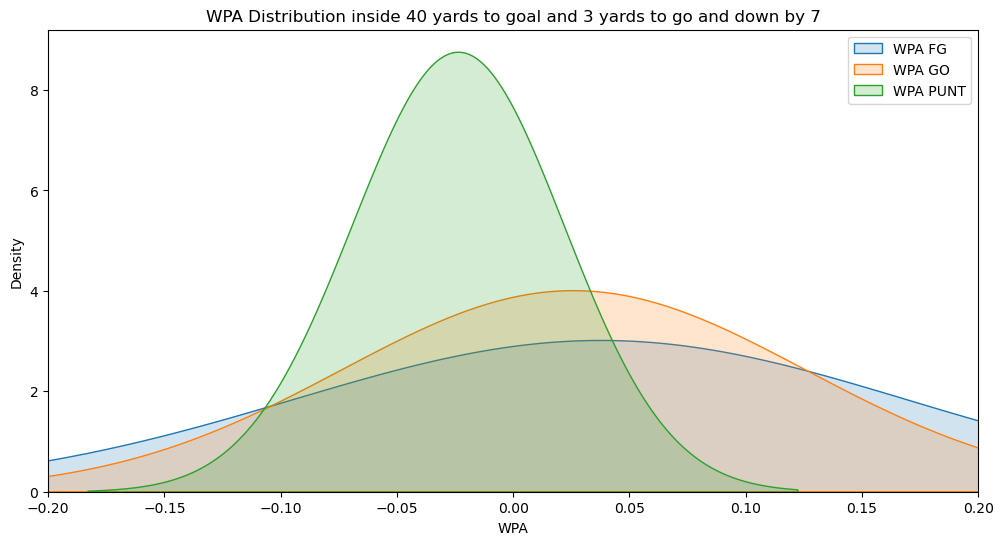

In [247]:
# plot a kde plot of wpa_fg, wpa_go, and wpa_punt using seaborn
import seaborn as sns
plt.figure(figsize=(12, 6))
BW=6
qry = res.query('0 <= yards_to_goal <= 10 and distance <= 1 and score_diff == -10 and pct_game_played >= 0.90')
sns.kdeplot(data=qry, x='wpa_fg', label='WPA FG', fill=True, alpha=0.2, bw_adjust=BW)
sns.kdeplot(data=qry, x='wpa_go', label='WPA GO', fill=True, alpha=0.2, bw_adjust=BW)
sns.kdeplot(data=qry, x='wpa_punt', label='WPA PUNT', fill=True, alpha=0.2, bw_adjust=BW)
plt.xlim(-.2, .2)
plt.xlabel('WPA')
plt.ylabel('Density')
plt.title('WPA Distribution inside 40 yards to goal and 3 yards to go and down by 7')
plt.legend()
plt.show()

In [248]:
cols = ['offense_score', 'defense_score',
       'yards_to_goal', 'pct_game_played', 'down', 'distance', 'wpa_fg',
       'wpa_go', 'wpa_punt', 'cur_win_proba', 'decision', 'recommendation']
res[cols].query('wpa_go > 0.04').head(30)

,offense_score,defense_score,yards_to_goal,pct_game_played,down,distance,wpa_fg,wpa_go,wpa_punt,cur_win_proba,decision,recommendation
3,0,0,97,0.114167,4,8,0.0395,0.049763,0.10530,0.4415,punt,punt - strongly recommended
1066,6,0,1,0.088611,4,1,0.0517,0.045399,-0.02210,0.7310,go,None
1242,27,26,1,0.889444,4,1,0.0006,0.052116,-0.01300,0.8125,field_goal,go - strongly recommended
1294,17,24,1,0.720278,4,1,0.0454,0.064639,-0.03390,0.4480,field_goal,go - slightly recommended
1377,14,7,1,0.440278,4,1,0.0464,0.042551,-0.02030,0.7375,go,None
1419,17,13,33,0.500000,4,10,0.0760,0.042168,0.05930,0.6220,go,field goal - slightly recommended
1579,17,7,17,0.500000,4,2,0.0828,0.046612,0.04490,0.7835,field_goal,field goal - recommended
2218,7,17,1,0.496667,4,1,0.0539,0.051802,-0.00560,0.1645,go,None
2247,0,0,88,0.040556,4,14,0.0230,0.040198,0.03150,0.9420,punt,None
2275,0,0,73,0.012778,4,8,0.0335,0.042779,0.06380,0.0405,punt,punt - slightly recommended


In [254]:
PREDICTIONS_DIR = os.path.join(DATA_DIR, 'predictions')
if not os.path.exists(PREDICTIONS_DIR):
    os.makedirs(PREDICTIONS_DIR)

res.to_parquet(
    os.path.join(PREDICTIONS_DIR, 'predictions.parquet'),
    index=False
)